In [43]:
# /kaggle/input/playground-series-s4e12/sample_submission.csv
# /kaggle/input/playground-series-s4e12/train.csv
# /kaggle/input/playground-series-s4e12/test.csv

import pandas as pd
from sklearn.model_selection import KFold

df = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
df = df.dropna(subset=['Premium Amount'])
x = df

kf = KFold(n_splits=3, shuffle=True, random_state=3)

In [44]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

x['Gender'] = label_encoder.fit_transform(x['Gender'])
x['Marital Status'] = label_encoder.fit_transform(x['Marital Status'])
x['Occupation'] = label_encoder.fit_transform(x['Occupation'])
x['Location'] = label_encoder.fit_transform(x['Location'])
x['Policy Type'] = label_encoder.fit_transform(x['Policy Type'])
x['Customer Feedback'] = label_encoder.fit_transform(x['Customer Feedback'])
x['Smoking Status'] = label_encoder.fit_transform(x['Smoking Status'])
x['Exercise Frequency'] = label_encoder.fit_transform(x['Exercise Frequency'])
x['Property Type'] = label_encoder.fit_transform(x['Property Type'])
x['Education Level'] = label_encoder.fit_transform(x['Education Level'])
# x['Education Level'] = x['Education Level'].map({"Bachelor's": 1, "Master's": 2, "High School": 0, "PhD": 3})
# x['Previous Claims'] = x['Previous Claims'].map({"NaN": -1})
# display(x)
# datetime columns
x['Policy Start Date'] = pd.to_datetime(x['Policy Start Date'])
# extract date features
# x['StartYear'] = x['Policy Start Date'].dt.year
# x['StartMonth'] = x['Policy Start Date'].dt.month
# x['StartDay'] = x['Policy Start Date'].dt.day
# x['StartWeekday'] = x['Policy Start Date'].dt.weekday 

from datetime import datetime

reference_date = datetime(1990,1,1)
x['DaysSinceStart'] = (x['Policy Start Date'] - reference_date).dt.days
x = x.drop(columns = ['Policy Start Date'])
display(x)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,DaysSinceStart
0,0,19.0,0,10049.0,1,1.0,0,1,22.598761,2,...,2.0,17.0,372.0,5.0,2,0,3,2,2869.0,12409
1,1,39.0,0,31678.0,0,3.0,2,3,15.569731,0,...,1.0,12.0,694.0,2.0,0,1,1,2,1483.0,12215
2,2,23.0,1,25602.0,0,3.0,1,1,47.177549,1,...,1.0,14.0,NaN,3.0,1,1,3,2,567.0,12325
3,3,21.0,1,141855.0,1,2.0,0,3,10.938144,0,...,1.0,0.0,367.0,1.0,2,1,0,0,765.0,12581
4,4,21.0,1,39651.0,2,1.0,0,1,20.376094,0,...,0.0,8.0,598.0,4.0,2,1,3,2,2022.0,11657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,36.0,0,27316.0,1,0.0,2,2,13.772907,2,...,NaN,5.0,372.0,3.0,2,0,0,0,1303.0,12175
1199996,1199996,54.0,1,35786.0,0,NaN,2,1,11.483482,0,...,NaN,10.0,597.0,4.0,2,0,3,0,821.0,11940
1199997,1199997,19.0,1,51884.0,0,0.0,2,3,14.724469,1,...,0.0,19.0,NaN,6.0,1,0,1,1,371.0,11467
1199998,1199998,55.0,1,NaN,2,1.0,3,3,18.547381,1,...,1.0,7.0,407.0,4.0,2,0,0,0,596.0,11584


In [40]:
from sklearn.impute import SimpleImputer

def impute_data(df):
    imputer = SimpleImputer(strategy='median')
    mean_imputer = SimpleImputer(strategy='mean')
    df['Annual Income'] = imputer.fit_transform(x[['Annual Income']])
    df['Credit Score'] = imputer.fit_transform(x[['Credit Score']])
    df['Age'] = mean_imputer.fit_transform(x[['Age']])
    df['Health Score'] = mean_imputer.fit_transform(x[['Health Score']])
    df['Number of Dependents'] = df['Number of Dependents'].fillna(0.0)
    df['Previous Claims'] = df['Previous Claims'].fillna(0.0)
    # df = df.dropna()
    return df
display(x)
# print(x.isna().sum()) 

/tmp/ipykernel_24/1814482186.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Annual Income'] = imputer.fit_transform(x[['Annual Income']])
/tmp/ipykernel_24/1814482186.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Credit Score'] = imputer.fit_transform(x[['Credit Score']])
/tmp/ipykernel_24/1814482186.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,DaysSinceStart
0,0,19.0,0,10049.0,1,1.0,0,1,22.598761,2,...,2.0,17.0,372.0,5.0,2,0,3,2,2869.0,12409
1,1,39.0,0,31678.0,0,3.0,2,3,15.569731,0,...,1.0,12.0,694.0,2.0,0,1,1,2,1483.0,12215
2,2,23.0,1,25602.0,0,3.0,1,1,47.177549,1,...,1.0,14.0,595.0,3.0,1,1,3,2,567.0,12325
3,3,21.0,1,141855.0,1,2.0,0,3,10.938144,0,...,1.0,0.0,367.0,1.0,2,1,0,0,765.0,12581
4,4,21.0,1,39651.0,2,1.0,0,1,20.376094,0,...,0.0,8.0,598.0,4.0,2,1,3,2,2022.0,11657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,36.0,0,27316.0,1,0.0,2,2,13.772907,2,...,0.0,5.0,372.0,3.0,2,0,0,0,1303.0,12175
1199996,1199996,54.0,1,35786.0,0,0.0,2,1,11.483482,0,...,0.0,10.0,597.0,4.0,2,0,3,0,821.0,11940
1199997,1199997,19.0,1,51884.0,0,0.0,2,3,14.724469,1,...,0.0,19.0,595.0,6.0,1,0,1,1,371.0,11467
1199998,1199998,55.0,1,23911.0,2,1.0,3,3,18.547381,1,...,1.0,7.0,407.0,4.0,2,0,0,0,596.0,11584


In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
y = x['Premium Amount']
x = x.drop(columns=['Premium Amount'])
fold = 1
mse_score = []

for i_train, i_test in kf.split(x):
    print(f"fold = {fold}")
    x_train, x_test = x.iloc[i_train], x.iloc[i_test]
    y_train, y_test = y.iloc[i_train], y.iloc[i_test]
    # display(y_train)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mse = mean_squared_error(y_test, y_pred)
    mse_score.append(mse)
    print(f"MSE for fold = {mse}")
    fold += 1

avg_mse = sum(mse_score)/len(mse_score)
print(f"Avg mse = {avg_mse}")

fold = 1
MSE for fold = 743283.7294029776
fold = 2
MSE for fold = 745524.1117687916
fold = 3
MSE for fold = 747956.1083604239
Avg mse = 745587.9831773977


array([1042.91534562, 1130.12909858, 1059.37825939, ..., 1064.41408322,
       1050.57958426, 1161.48587665])

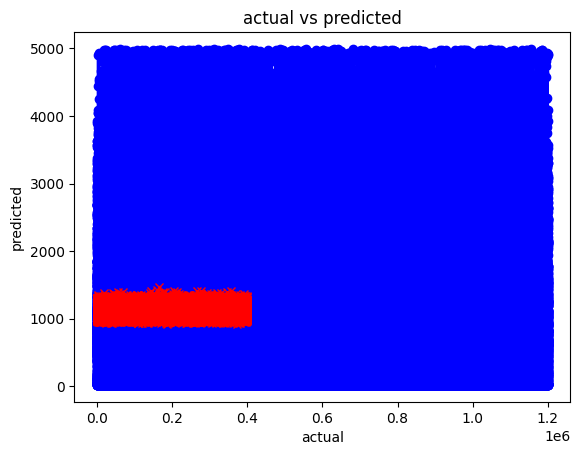

In [42]:
display(y_pred)
import numpy as np
# display(y_test)

import matplotlib.pyplot as plt
colors = np.random.rand(2)
plt.plot(y_test, label='Actual Values', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', color='red')
# plt.plot([min(y_test.values), max(y_test)], [min(y_test.values), max(y_test)], color='red', linewidth=2)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('actual vs predicted')
plt.show()

In [ ]:
display(y_test.values)